In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

In [2]:
# Geting the data

In [3]:
main_df=pd.read_csv("CBAData.csv",parse_dates=["Date"], index_col=["Date"])
main_df = main_df.dropna()
main_df.head()

,USD
Date,
2002-01-31,564.39
2002-02-28,568.18
2002-03-31,576.96
2002-04-30,579.34
2002-05-31,582.22


In [4]:
# Ploting the data 

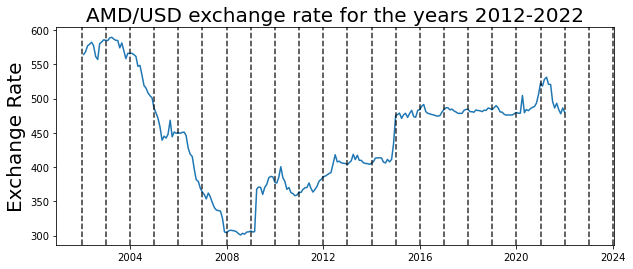

In [5]:
plt.figure(figsize=(10,4))
plt.plot(main_df.USD)
plt.title("AMD/USD exchange rate for the years 2012-2022" ,fontsize=20)
plt.ylabel("Exchange Rate",fontsize=20)
for year in range(2002,2025):
    plt.axvline(pd.to_datetime(str(year)+"-01-01"),color="k",linestyle="--",alpha=0.8)

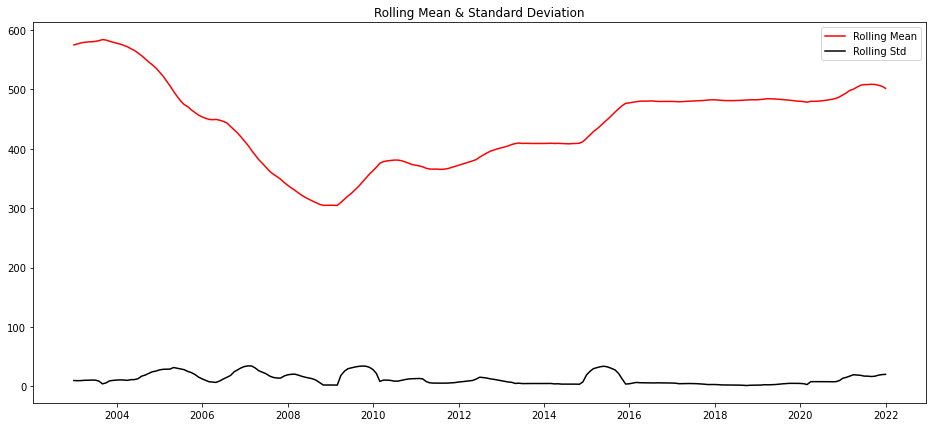

In [6]:
rolLmean = main_df.USD.rolling(12).mean()
rolLstd = main_df.USD.rolling(12).std()

plt.figure(figsize=(16,7))
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [7]:
# To understand stationarity 
# ADF - p-value > 0.05 => non stationary 
# KPSS - p-value > 0.05 => trend-stationarity 
# We have some trend 

In [8]:
# ADF

from statsmodels.tsa.stattools import adfuller

X1 = main_df.USD
result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.572424
p-value: 0.098832
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [9]:
# KPSS

from statsmodels.tsa.stattools import kpss
result = kpss(X1)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.314970
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [10]:
# In PACF - 2 leg 

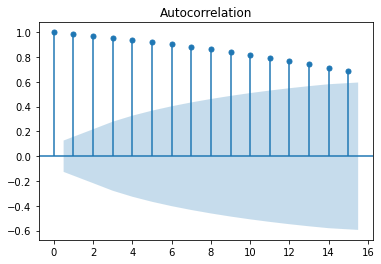

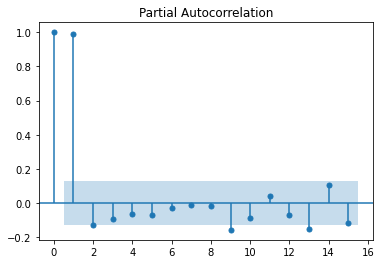

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot1 = plot_acf(X1,lags=15)
pacf_plot1 = plot_pacf(X1,lags=15)

In [12]:
# Spliting into train/test (90/10)

In [13]:
train1 = main_df[:int(X1.shape[0]*0.9)]
test1 = main_df[int(X1.shape[0]*0.9):]

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics  import mean_squared_error

In [15]:
# BruteForce approach to understand best model 

In [16]:
import itertools
p1=range(0,4)
q1=range(0,4)
d1=range(1,3)
pdq_combos1 =list(itertools.product(p1,d1,q1))
rmse1=[]  
order1=[]

In [17]:
for pdq in pdq_combos1:
    try:
        modelnew1=ARIMA(train1,order=pdq).fit()
        pred1=modelnew1.predict(start=len(train1),end=(len(main_df.USD)-1))
        error1=np.sqrt(mean_squared_error(test1,pred1))
        order1.append(pdq)
        rmse1.append(error1)
    except:
        continue

In [18]:
# RMSE suggest that the best model is (2,2,2)

In [19]:
results1=pd.DataFrame(index=order1,data=rmse1,columns=["RMSE"])
results1.sort_values(by=["RMSE"], inplace=True)
results1.head()

,RMSE
"(2, 2, 2)",496.676391
"(0, 2, 0)",496.691938
"(1, 2, 0)",496.699829
"(2, 2, 0)",496.710810
"(3, 2, 0)",496.721607


In [20]:
# raining that model 

In [21]:
model1=ARIMA(train1,order=(2,2,2))
fitted1=model1.fit()
print(fitted1.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.USD   No. Observations:                  214
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -757.289
Method:                       css-mle   S.D. of innovations              8.246
Date:                Wed, 11 May 2022   AIC                           1526.577
Time:                        16:52:40   BIC                           1546.773
Sample:                             2   HQIC                          1534.738
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0178      0.016      1.095      0.273      -0.014       0.050
ar.L1.D2.USD     1.0066      0.170      5.927      0.000       0.674       1.339
ar.L2.D2.USD    -0.0800      0.083     -0.96

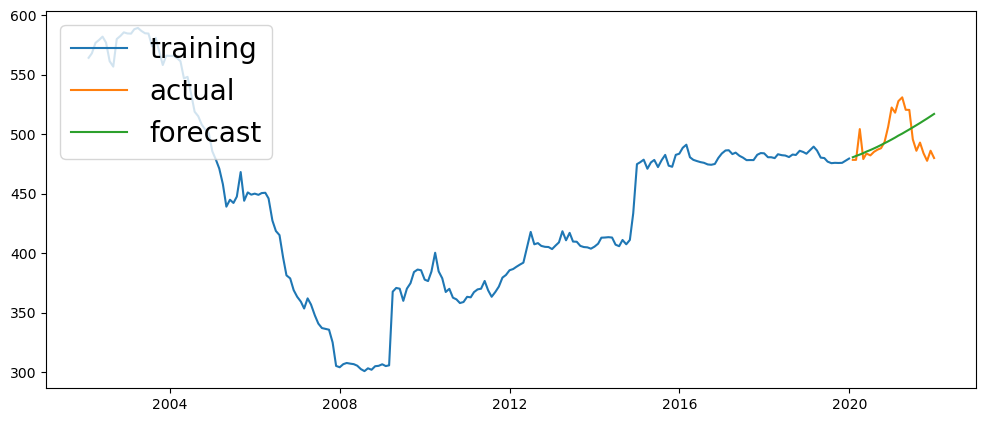

In [22]:
fc1,se1,const1=fitted1.forecast(len(test1),alpha=0.05)
fc_series1 = pd.Series(fc1, index=test1.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='training')
plt.plot(test1, label='actual')
plt.plot(fc_series1, label='forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [23]:
# SARIMA

In [24]:
from datetime import datetime
start_date_SARIMA = datetime(2016,1,1)
end_date_SARIMA = datetime(2019,1,1)
main_df_SARIMA = main_df[start_date_SARIMA:end_date_SARIMA]

In [25]:
X2 = main_df_SARIMA.USD
train1_SARIMA = main_df_SARIMA[:int(X2.shape[0]*0.9)]
test1_SARIMA = main_df_SARIMA[int(X2.shape[0]*0.9)-1:]

In [26]:
model_SARIMA = pm.auto_arima(train1_SARIMA, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=1,          
                                           start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_SARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=158.671, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=156.621, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=157.110, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=156.700, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=154.750, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=155.995, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=155.304, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=157.302, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=158.176, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=158.250, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=160.136, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.631 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 

In [27]:
my_order = (0,1,0)
my_seasonal_order = (0, 0, 0, 12)
# define model
model2 = SARIMAX(train1_SARIMA, order=my_order, seasonal_order=my_seasonal_order)
fitted2 = model2.fit()
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                    USD   No. Observations:                   32
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -76.375
Date:                Wed, 11 May 2022   AIC                            154.750
Time:                        16:52:41   BIC                            156.184
Sample:                             0   HQIC                           155.217
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.0812      1.184      6.827      0.000       5.761      10.401
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                24.86
Prob(Q):                              0.49   Pr

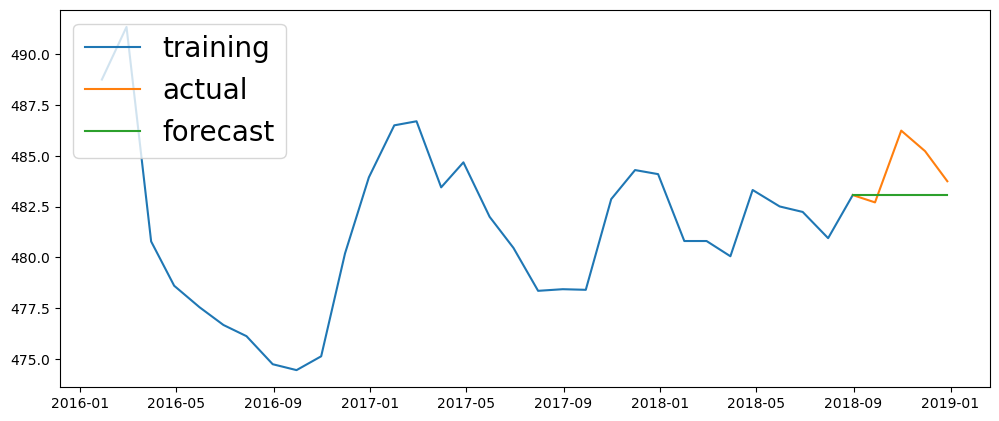

In [28]:
fc2 = np.array(fitted2.forecast(len(test1_SARIMA)))
fc_series2 = pd.Series(fc2, index=test1_SARIMA.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1_SARIMA, label='training')
plt.plot(test1_SARIMA, label='actual')
plt.plot(fc_series2, label='forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [29]:
model_o=ARIMA(main_df.USD,order=(2,2,2))
fitted_o=model_o.fit()
print(fitted_o.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.USD   No. Observations:                  238
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -853.095
Method:                       css-mle   S.D. of innovations              8.636
Date:                Wed, 11 May 2022   AIC                           1718.190
Time:                        16:52:42   BIC                           1739.024
Sample:                             2   HQIC                          1726.586
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0130      0.014      0.946      0.344      -0.014       0.040
ar.L1.D2.USD     0.9281      0.218      4.261      0.000       0.501       1.355
ar.L2.D2.USD    -0.0248      0.083     -0.29

In [30]:
# FOR ORIGINAL WE CHOOSE ARIMA

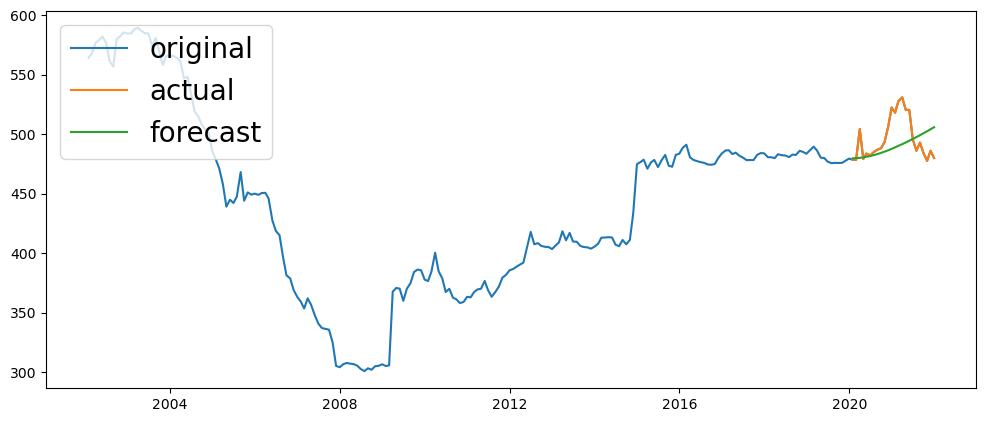

In [31]:
fc_o,se_o,const_o=fitted_o.forecast(len(test1),alpha=0.05)
fc_series_o = pd.Series(fc_o, index=test1.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(main_df.USD, label='original')
plt.plot(test1, label='actual')
plt.plot(fc_series_o, label='forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [32]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
main_df['USD']

Date
2002-01-31    564.39
2002-02-28    568.18
2002-03-31    576.96
2002-04-30    579.34
2002-05-31    582.22
               ...  
2021-08-31    493.12
2021-09-30    484.20
2021-10-31    477.80
2021-11-30    486.28
2021-12-30    480.14
Name: USD, Length: 240, dtype: float64

In [34]:
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

#parser('1/31/2002')
# df=pd.read_csv("CBAData.csv",parse_dates=[0], index_col=[0], squeeze=True, date_parser=parser)

# df

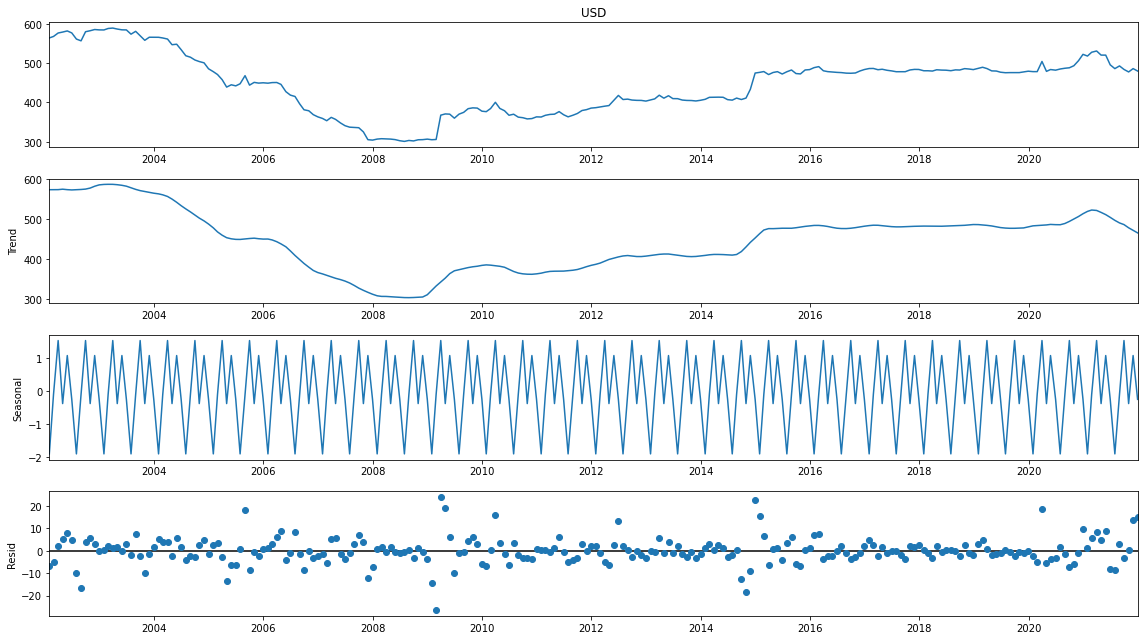

In [35]:
decomp_viz = sm.tsa.seasonal_decompose(main_df['USD'], model='additive', extrapolate_trend='freq', period=int(len(test1)/4))
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

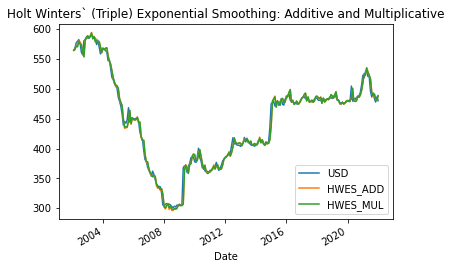

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

main_df['HWES_ADD'] = ExponentialSmoothing(main_df['USD'],trend='add',seasonal='add',seasonal_periods=12, initialization_method='estimated').fit().fittedvalues
main_df['HWES_MUL'] = ExponentialSmoothing(main_df['USD'],trend='mul',seasonal='mul',seasonal_periods=12, initialization_method='estimated').fit().fittedvalues
main_df[['USD','HWES_ADD','HWES_MUL']].plot(title='Holt Winters` (Triple) Exponential Smoothing: Additive and Multiplicative');

In [37]:
mean_squared_error(main_df.USD, main_df.HWES_ADD)

66.88491394279184

In [38]:
mean_squared_error(main_df.USD, main_df.HWES_MUL)

67.09091183261852

In [39]:
# Take additive model 

In [40]:
main_df

,USD,HWES_ADD,HWES_MUL
Date,,,
2002-01-31,564.39,564.390380,564.398238
2002-02-28,568.18,565.871311,565.657567
2002-03-31,576.96,572.918470,571.801752
2002-04-30,579.34,572.300317,570.130851
2002-05-31,582.22,579.906762,579.178248
...,...,...,...
2021-08-31,493.12,487.274782,488.098164
2021-09-30,484.20,491.078145,491.341342
2021-10-31,477.80,484.110914,484.628848


<AxesSubplot:title={'center':'Currency'}, xlabel='Date'>

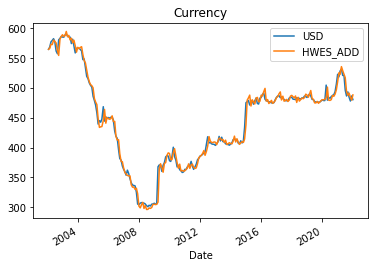

In [41]:
main_df[['USD','HWES_ADD']].plot(title='Currency')

In [42]:
# ARCH-GARCH

In [43]:
from arch import arch_model

In [44]:
returns = 100 * main_df['USD'].pct_change().dropna()
return_sq=returns**2

In [45]:
model_g = pm.auto_arima(returns, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=5,              # frequency of series
                      d=False,           # let model determine 'd'
                      seasonal=False,  # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_g.summary())

Performing stepwise search to minimize aic
 ARIMA(1,False,1)(0,0,0)[0]             : AIC=1052.779, Time=0.13 sec
 ARIMA(0,False,0)(0,0,0)[0]             : AIC=1054.754, Time=0.01 sec
 ARIMA(1,False,0)(0,0,0)[0]             : AIC=1053.386, Time=0.04 sec
 ARIMA(0,False,1)(0,0,0)[0]             : AIC=1053.675, Time=0.05 sec
 ARIMA(2,False,1)(0,0,0)[0]             : AIC=1054.481, Time=0.20 sec
 ARIMA(1,False,2)(0,0,0)[0]             : AIC=1057.059, Time=0.11 sec
 ARIMA(0,False,2)(0,0,0)[0]             : AIC=1055.054, Time=0.08 sec
 ARIMA(2,False,0)(0,0,0)[0]             : AIC=1054.991, Time=0.08 sec
 ARIMA(2,False,2)(0,0,0)[0]             : AIC=1056.709, Time=0.38 sec
 ARIMA(1,False,1)(0,0,0)[0] intercept   : AIC=1054.739, Time=0.29 sec

Best model:  ARIMA(1,False,1)(0,0,0)[0]          
Total fit time: 1.387 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  239
Model:            

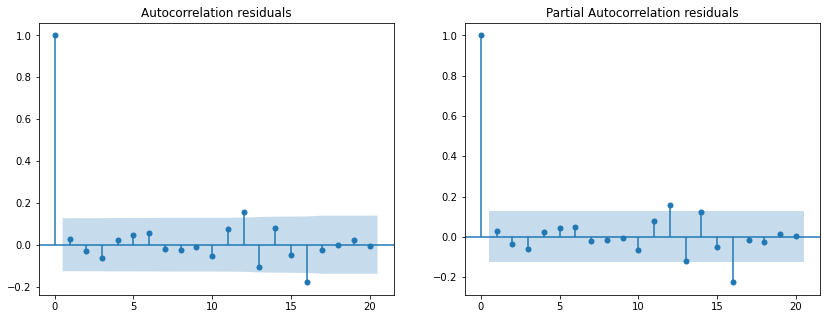

In [46]:
residuals_arma = model_g.resid()

fig, ax = plt.subplots(1,2,figsize=(14,5))
fig.subplots_adjust(hspace = 0.5)

plot_acf(residuals_arma, lags=20, ax=ax[0], title = "Autocorrelation residuals")
plot_pacf(residuals_arma, lags=20, ax=ax[1], title = "Partial Autocorrelation residuals")
plt.show()

In [47]:
#  From ACF and PACF it seems to be white noise

In [48]:
# From the Ljung-box p-value > 0.05 => white noise 

In [49]:
# Considering teh sequence of residuals 

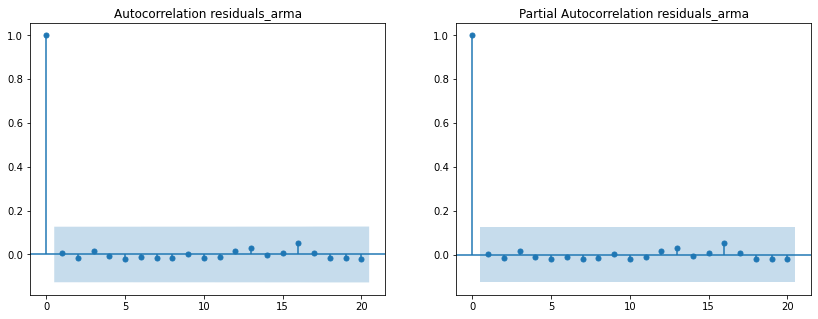

In [50]:
residuals_arma_sq = residuals_arma**2
fig, ax = plt.subplots(1,2,figsize=(14,5))
fig.subplots_adjust(hspace = 0.5)

plot_acf(residuals_arma_sq, lags=20, ax=ax[0], title = "Autocorrelation residuals_arma")
plot_pacf(residuals_arma_sq, lags=20, ax=ax[1], title = "Partial Autocorrelation residuals_arma")
plt.show()

In [51]:
model_res_arma = arch_model(residuals_arma, mean='Zero', vol='Garch', p=1, o=0, q=1, dist='Normal')
res_arma = model_res_arma.fit(update_freq=5)
print(res_arma.summary())

Iteration:      5,   Func. Count:     24,   Neg. LLF: 523.0917289087366
Iteration:     10,   Func. Count:     49,   Neg. LLF: 535.2312403026973
Iteration:     15,   Func. Count:     75,   Neg. LLF: 534.8237176125568
Iteration:     20,   Func. Count:     99,   Neg. LLF: 533.5442937548587
Iteration:     25,   Func. Count:    126,   Neg. LLF: 538.0583945120186
Iteration:     30,   Func. Count:    148,   Neg. LLF: 521.5141570122952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 521.5141570122952
            Iterations: 35
            Function evaluations: 151
            Gradient evaluations: 31
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -521.514
Distribution:                  Normal   AI

In [52]:
forecasts = res_arma.forecast(horizon=len(test1))

In [53]:
print(forecasts.variance.dropna().head())

         h.01      h.02      h.03      h.04     h.05      h.06      h.07  \
238  4.918113  4.918115  4.918117  4.918119  4.91812  4.918122  4.918123   

         h.08      h.09      h.10  ...      h.15      h.16      h.17  \
238  4.918125  4.918126  4.918127  ...  4.918133  4.918134  4.918135   

         h.18      h.19      h.20      h.21      h.22      h.23     h.24  
238  4.918136  4.918136  4.918137  4.918138  4.918139  4.918139  4.91814  

[1 rows x 24 columns]


In [54]:
#VAR 

In [55]:
var_df=pd.read_csv("CBA_VARData.csv",parse_dates=["Date"], index_col=["Date"])
var_df = var_df.dropna()
var_df.head()

,RUB,USD
Date,,
2015-01-13,7.33,477.04
2015-01-14,7.25,478.09
2015-01-15,7.36,478.24
2015-01-16,7.35,478.45
2015-01-19,7.41,478.28


In [56]:
start_date = datetime(2015,1,13)
end_date = datetime(2019,12,30)
var_df = var_df[start_date:end_date]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

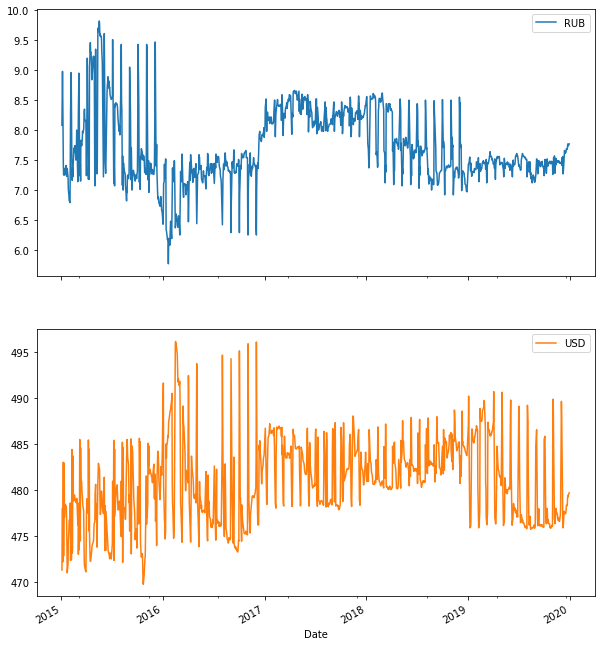

In [57]:
var_df.plot(subplots=True, figsize=(10,12))

In [58]:
X_train_var = var_df[:int(var_df.shape[0]*0.9)]
X_test_var = var_df[int(var_df.shape[0]*0.9 ):]
print(X_train_var.shape)
print(X_test_var.shape)

(1119, 2)
(125, 2)


In [59]:
transform_data = X_train_var.diff().dropna()
transform_data.head()

,RUB,USD
Date,,
2015-01-14,-0.08,1.05
2015-01-15,0.11,0.15
2015-01-16,-0.01,0.21
2015-01-19,0.06,-0.17
2015-01-20,-0.07,-0.37


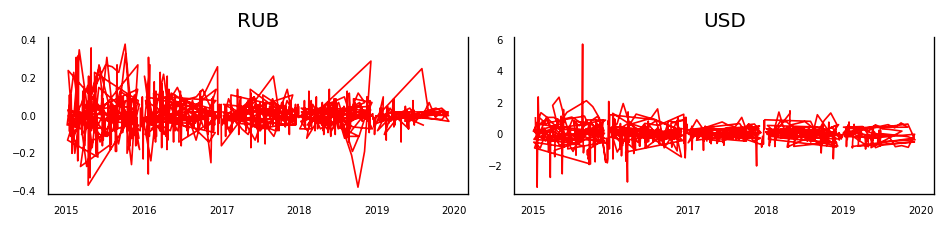

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(8, 2))
for i, ax in enumerate(axes.flatten()):
    data = transform_data[transform_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(transform_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [61]:
from statsmodels.tsa.api import VAR
model=VAR(transform_data)
a=model.select_order(maxlags=15)
a.summary()

,AIC,BIC,FPE,HQIC
0,-6.145,-6.135,0.002145,-6.141
1,-6.385,-6.358*,0.001686,-6.375*
2,-6.384,-6.339,0.001688,-6.367
3,-6.395,-6.332,0.001669,-6.371
4,-6.394,-6.312,0.001672,-6.363
5,-6.396*,-6.296,0.001669*,-6.358
6,-6.391,-6.273,0.001676,-6.346
7,-6.391,-6.255,0.001677,-6.339
8,-6.393,-6.238,0.001674,-6.334
9,-6.390,-6.218,0.001678,-6.325


In [62]:
from statsmodels.tsa.stattools import grangercausalitytests

# creating a variable named 'maxlag' and assigning the integer 5
maxlag = 5

# assigning the string 'ssr_chi2test' to the variable 'test'
test = 'ssr_chi2test'

# creating a function named 'granger_causation_matrix' with the arguments 'data', 'variables', 'test', and 'verbose'
def granger_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    
    # creating a dataframe with the same dimensions as number of variables entered, assigned to the variable 'X_train'
    X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    # loops through the columns and the indexes
    for c in X_train.columns:
        for r in X_train.index:
            
            # conducts a granger causality test on a variable row and column using the 'maxlag' variable; assigns to 
            # variable test_result
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            
            # locates the test result in the tuple 'test_result' and rounds the number by 4 digits; assigns to 'p_values'
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            # if the variable is 'verbose', print the y and x variables and the associated p-value
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            
            # find the smallest p-value and assign to variable 'min_p_value'
            min_p_value = np.min(p_values)
            
            # find the smallest p-value and assign to its respective row and column
            X_train.loc[r, c] = min_p_value
            
    # remane the row and column names based on the relationship
    X_train.columns = [var + '_x' for var in variables]
    X_train.index = [var + '_y' for var in variables]
    return X_train

In [63]:
granger_causation_matrix(X_train_var, variables = X_train_var.columns)

,RUB_x,USD_x
RUB_y,1.0000,0.3459
USD_y,0.0023,1.0000


In [64]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
mod = smt.VAR(transform_data)
res = mod.fit(maxlags= 1, ic = 'aic')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, May, 2022
Time:                     16:52:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.28161
Nobs:                     1117.00    HQIC:                  -6.29838
Log likelihood:           359.426    FPE:                 0.00182064
AIC:                     -6.30857    Det(Omega_mle):      0.00181090
--------------------------------------------------------------------
Results for equation RUB
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000193         0.002409            0.080           0.936
L1.RUB         0.024427         0.029987            0.815           0.415
L1.USD         0.002039         0.004012            0.508           0.611

Results for equ

In [65]:
lag_order = res.k_ar

In [66]:
pred = res.forecast(transform_data.values[-lag_order:], len(X_test_var))
pred_df = pd.DataFrame(pred, index=var_df.index[-len(X_test_var):], columns = var_df.columns)
pred_df

,RUB,USD
Date,,
2019-09-07,-0.001253,-0.020218
2019-10-07,0.000121,-0.009646
2019-11-07,0.000176,-0.005562
2019-12-07,0.000186,-0.003675
2019-07-15,0.000190,-0.002793
...,...,...
2019-12-24,0.000193,-0.002018
2019-12-25,0.000193,-0.002018
2019-12-26,0.000193,-0.002018


In [67]:
# reversing the difference and assigning to variable 'pred_inverse'
pred_inverse = pred_df.cumsum() 

# inverse the difference values and assigning to variable 'f'
f = pred_inverse + X_test_var
print(f)

                 RUB         USD
Date                            
2019-09-07  7.468747  476.979782
2019-10-07  7.478868  476.560137
2019-11-07  7.569044  476.904575
2019-12-07  7.559230  476.640900
2019-07-15  7.609420  476.638106
...              ...         ...
2019-12-24  7.741859  478.873346
2019-12-25  7.792053  479.071328
2019-12-26  7.782246  478.989310
2019-12-27  7.762440  479.217292
2019-12-30  7.792633  479.415274

[125 rows x 2 columns]


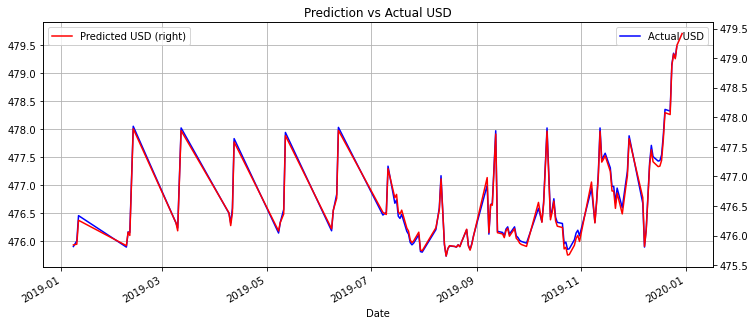

In [68]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1_USD = X_test_var.USD.plot(color='blue', grid=True, label='Actual USD')
ax2_USD = f.USD.plot(color='red', grid=True, secondary_y=True, label='Predicted USD')

ax1_USD.legend(loc=1)
ax2_USD.legend(loc=2)
plt.title('Prediction vs Actual USD')
plt.show()

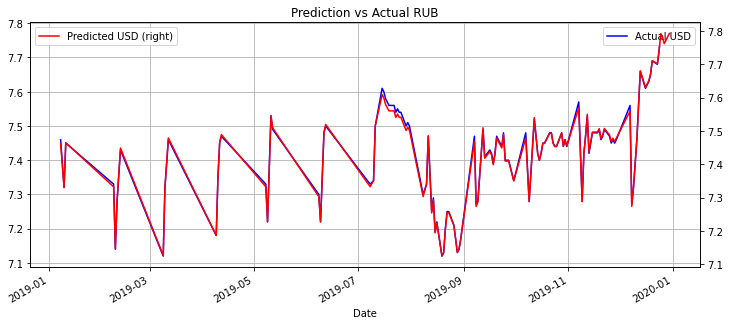

In [69]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1_RUB = X_test_var.RUB.plot(color='blue', grid=True, label='Actual USD')
ax2_RUB = f.RUB.plot(color='red', grid=True, secondary_y=True, label='Predicted USD')

ax1_RUB.legend(loc=1)
ax2_RUB.legend(loc=2)
plt.title('Prediction vs Actual RUB')
plt.show()